<a href="https://colab.research.google.com/github/AndriiHomeniuk1/TinyVGG-Data-Augmentation/blob/main/TinyVGG_with_DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import os
import zipfile
import requests
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from typing import Dict, List, Tuple
from timeit import default_timer as timer
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

In [ ]:
# setting up device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [ ]:
# downloading dataset from kaggle
!kaggle datasets download -d sanikamal/horses-or-humans-dataset

Dataset URL: https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset
License(s): other
 98% 300M/307M [00:07<00:00, 22.8MB/s]
100% 307M/307M [00:07<00:00, 43.4MB/s]


In [ ]:
with zipfile.ZipFile("/content/horses-or-humans-dataset.zip", "r") as zip_ref:
  print("Unzipping data...")
  zip_ref.extractall("data")

Unzipping data...


In [ ]:
# remove extra folder "horse-or-human"
!rm -rf /content/data/horse-or-human/horse-or-human

In [ ]:
# rename folder name from validation to test
!mv /content/data/horse-or-human/validation /content/data/horse-or-human/test

In [ ]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir("/content/data")

There are 1 directories and 0 images in '/content/data'.
There are 2 directories and 0 images in '/content/data/horse-or-human'.
There are 2 directories and 0 images in '/content/data/horse-or-human/test'.
There are 0 directories and 128 images in '/content/data/horse-or-human/test/horses'.
There are 0 directories and 128 images in '/content/data/horse-or-human/test/humans'.
There are 2 directories and 0 images in '/content/data/horse-or-human/train'.
There are 0 directories and 500 images in '/content/data/horse-or-human/train/horses'.
There are 0 directories and 527 images in '/content/data/horse-or-human/train/humans'.


In [ ]:
data_path = Path("data/")
image_path = data_path / "horse-or-human"

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/horse-or-human/train'), PosixPath('data/horse-or-human/test'))

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

Target dir: data/horse-or-human/train


In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)


(['horses', 'humans'], {'horses': 0, 'humans': 1})

#Create a custom Dataset to replicate ImageFolder

In [ ]:
class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.png"))  # Change format if need
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path).convert('RGB')  # Convert to RGB!!!

  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

#Create transform with data augmentation

In [ ]:
# Create training transform with TriviailAugment
train_transform_trivial = transforms.Compose([
                                               transforms.Resize(size=(64, 64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()
])

In [ ]:
train_transform_trivial, test_transform_simple

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

#Creating train and test dataset's and dataLoader's with data augmentation

In [ ]:
# Turn image folders into Datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [ ]:
train_data_augmented, test_data_simple


(Dataset ImageFolder
     Number of datapoints: 1027
     Root location: data/horse-or-human/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 256
     Root location: data/horse-or-human/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Turn our Datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

#Display random images from the ImageFolder with data augmentation

In [ ]:
# This function randomly selects and displays images from a given dataset.
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

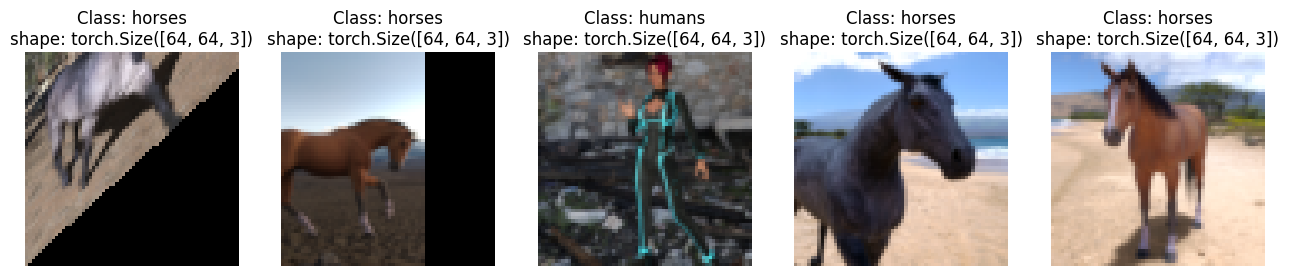

In [ ]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data_augmented,
                      n=5,
                      classes=train_data_augmented.classes,
                      seed=None)

#Construct and train model

TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x


In [ ]:
# Create model and send it to the target device
model = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_augmented))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a forward pass
model(image_batch.to(device))

tensor([[ 0.0398, -0.0159],
        [ 0.0386, -0.0171],
        [ 0.0471, -0.0163],
        [ 0.0358, -0.0153],
        [ 0.0414, -0.0160],
        [ 0.0357, -0.0133],
        [ 0.0408, -0.0156],
        [ 0.0364, -0.0119],
        [ 0.0411, -0.0121],
        [ 0.0339, -0.0185],
        [ 0.0402, -0.0116],
        [ 0.0354, -0.0173],
        [ 0.0358, -0.0164],
        [ 0.0392, -0.0108],
        [ 0.0352, -0.0177],
        [ 0.0398, -0.0162],
        [ 0.0341, -0.0147],
        [ 0.0376, -0.0186],
        [ 0.0406, -0.0136],
        [ 0.0387, -0.0200],
        [ 0.0383, -0.0166],
        [ 0.0374, -0.0156],
        [ 0.0405, -0.0076],
        [ 0.0416, -0.0103],
        [ 0.0353, -0.0188],
        [ 0.0437, -0.0156],
        [ 0.0362, -0.0144],
        [ 0.0407, -0.0202],
        [ 0.0387, -0.0155],
        [ 0.0389, -0.0167],
        [ 0.0352, -0.0165],
        [ 0.0334, -0.0124]], grad_fn=<AddmmBackward0>)

In [ ]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

# Create train and test loops functions

In [ ]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X) # output model logits

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_logits = model(X)

      # Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

#function to combine train_step() and test_step()


In [ ]:
# Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

#Train and evaluate model

In [ ]:
NUM_EPOCHS = 8

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

start_time = timer()

model_results = train(model=model,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.6795 | Train acc: 0.5448 | Test loss: 0.6779 | Test acc: 0.5000
Epoch: 1 | Train loss: 0.6262 | Train acc: 0.6332 | Test loss: 0.6451 | Test acc: 0.5469
Epoch: 2 | Train loss: 0.5436 | Train acc: 0.7068 | Test loss: 1.3303 | Test acc: 0.5000
Epoch: 3 | Train loss: 0.5591 | Train acc: 0.7086 | Test loss: 0.5888 | Test acc: 0.6211
Epoch: 4 | Train loss: 0.4769 | Train acc: 0.7803 | Test loss: 0.4723 | Test acc: 0.7539
Epoch: 5 | Train loss: 0.4215 | Train acc: 0.7955 | Test loss: 0.3607 | Test acc: 0.8789
Epoch: 6 | Train loss: 0.4499 | Train acc: 0.7762 | Test loss: 0.2936 | Test acc: 0.9141
Epoch: 7 | Train loss: 0.4512 | Train acc: 0.8024 | Test loss: 0.2831 | Test acc: 0.8906
Total training time for model_1: 93.075 seconds


In [ ]:
model_results

{'train_loss': [0.6795025178880403,
  0.6262008493596857,
  0.5436499922564535,
  0.5591039991740024,
  0.476901830145807,
  0.42152893091693067,
  0.4499164724891836,
  0.4512353115009539],
 'train_acc': [0.5448232323232324,
  0.6332070707070707,
  0.7067550505050505,
  0.70864898989899,
  0.7803030303030303,
  0.7954545454545454,
  0.7761994949494949,
  0.80239898989899],
 'test_loss': [0.6778890304267406,
  0.6450970098376274,
  1.3303389931097627,
  0.5888257119804621,
  0.4723133370280266,
  0.36066969111561775,
  0.29355163499712944,
  0.2830780950607732],
 'test_acc': [0.5,
  0.546875,
  0.5,
  0.62109375,
  0.75390625,
  0.87890625,
  0.9140625,
  0.890625]}

# loss curves of model

In [ ]:
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

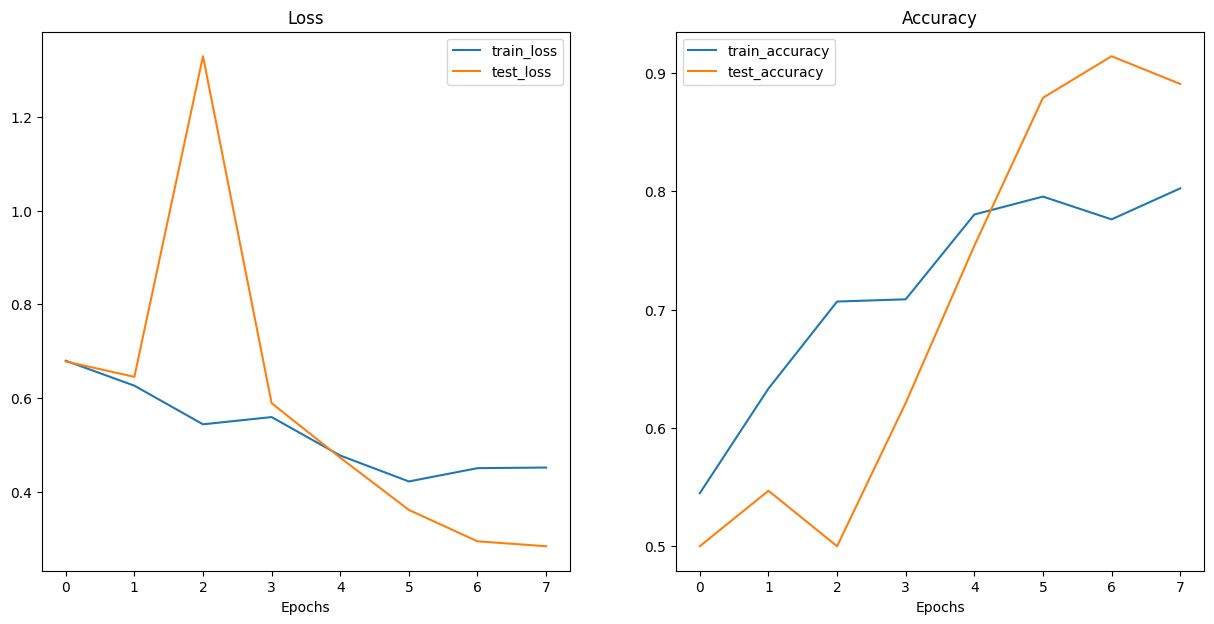

In [ ]:
plot_loss_curves(model_results)


In [ ]:
model_df = pd.DataFrame(model_results)
model_df

,train_loss,train_acc,test_loss,test_acc
0,0.679503,0.544823,0.677889,0.500000
1,0.626201,0.633207,0.645097,0.546875
2,0.543650,0.706755,1.330339,0.500000
3,0.559104,0.708649,0.588826,0.621094
4,0.476902,0.780303,0.472313,0.753906
5,0.421529,0.795455,0.360670,0.878906
6,0.449916,0.776199,0.293552,0.914062
7,0.451235,0.802399,0.283078,0.890625


#Making a prediction on a custom image

In [ ]:
# URL of the file to be downloaded
download_link = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTHPJyCnbd0zJFf9lsNzSQcQv7c25LJcIYHICnQFuyxkQ&s'
# Send a GET request to the URL
response = requests.get(download_link)

# Check if the request was successful
if response.status_code == 200:
    file_data = response.content

    # Save the file to the desired location
    with open('downloaded_file.jpg', 'wb') as f:
        f.write(file_data)
        print('File downloaded successfully!')
else:
    print('Failed to download file. Status code:', response.status_code)

File downloaded successfully!


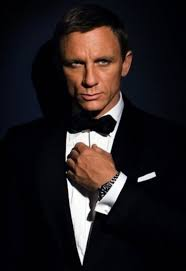

In [ ]:
custom_image_path = "/content/downloaded_file.jpg"

open_custom_image = Image.open(custom_image_path)
open_custom_image

In [ ]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255

print(f"Custom image tensor:\n {custom_image}")
print(f"Custom image shape: {custom_image.shape}")
print(f"Custom image datatype: {custom_image.dtype}")

Custom image tensor:
 tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0078],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0078]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0078]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  .

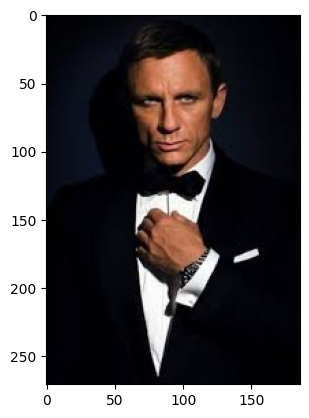

In [ ]:
plt.imshow(custom_image.permute(1, 2, 0))

In [ ]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
                                             transforms.Resize(size=(64, 64))
])

# Transfrom target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 271, 186])
Transformed shape: torch.Size([3, 64, 64])


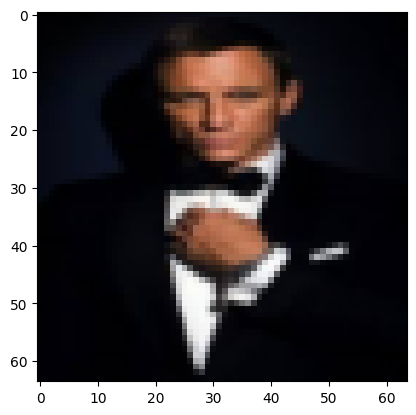

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device))

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert predction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)


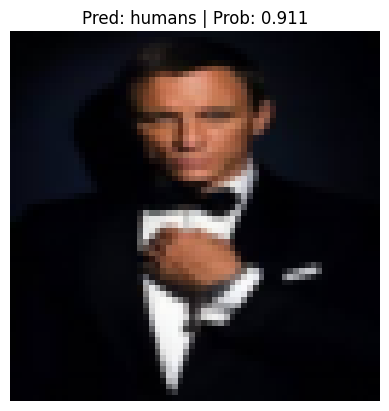

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=train_data_augmented.classes,
                    transform=custom_image_transform,
                    device=device)

#Saving and loading a model

In [ ]:
# !rm -rf /content/saved_models

In [ ]:
MODEL_PATH = Path("saved_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_TinyVGG_Data_with_Augmentation.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

model_params = {
    "input_shape": 3,
    "hidden_units": 10,
    "output_shape": len(train_data_augmented.classes)
}

model_state = {
    "state_dict": model.state_dict(),
    "params": model_params
}
torch.save(model_state, MODEL_SAVE_PATH)
print(f"Model and parameters saved to: {MODEL_SAVE_PATH}")

Model and parameters saved to: saved_models/01_TinyVGG_Data_with_Augmentation.pth


In [ ]:
model_state = torch.load(MODEL_SAVE_PATH)

model_params = model_state["params"]

loaded_model_1 = TinyVGG(input_shape=model_params["input_shape"],
                         hidden_units=model_params["hidden_units"],
                         output_shape=model_params["output_shape"])

loaded_model_1.load_state_dict(model_state["state_dict"])

loaded_model_1.to(device)
print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)
Model on device:
cpu


#Evaluate the loaded model

In [ ]:
all_preds = []
all_labels = []

loaded_model_1.eval()
with torch.inference_mode():
    for X_batch, y_batch in test_dataloader_simple:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = loaded_model_1(X_batch)
        all_preds.append(y_pred)
        all_labels.append(y_batch)

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels.cpu(), torch.argmax(all_preds, dim=1).cpu())
print(f"Accuracy of the loaded model on the test set: {accuracy:.4f}")

Accuracy of the loaded model on the test set: 0.8906
